In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    precision_score, recall_score, accuracy_score, f1_score,
    log_loss, plot_roc_curve, plot_precision_recall_curve
)
from sklearn.base import BaseEstimator, ClassifierMixin

Read the data

In [2]:
df = pd.read_csv('bioresponse.csv')

Separate the dataframe into feature matrix and labels. Split the data into train and test sets.  
**Note**: Additionally we will leave a validation part of 25% of test set to use as a dataset to estimate the binarization threshold to build an FN-avoiding classifier.

In [3]:
X = df.drop(columns='Activity')
y = df['Activity']

X_train, X_, y_train, y_ = train_test_split(X, y, train_size=0.75)
X_val, X_test, y_val, y_test = train_test_split(X_, y_, test_size=0.75)

Create and train the classifiers

In [4]:
shallow_dt = DecisionTreeClassifier(max_depth=10)
deep_dt = DecisionTreeClassifier(max_depth=100)
shallow_rf = RandomForestClassifier(n_estimators=500, max_depth=10)
deep_rf = RandomForestClassifier(n_estimators=500, max_depth=100)

In [5]:
shallow_dt.fit(X_train, y_train)
deep_dt.fit(X_train, y_train)
shallow_rf.fit(X_train, y_train)
deep_rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=100, n_estimators=500)

In [6]:
def test_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    logloss = log_loss(y_test, y_pred)
    print(f'Accuracy: {accuracy}')
    print(f'Recall: {recall}')
    print(f'Precision: {precision}')
    print(f'F1: {f1}')
    print(f'Log-loss: {logloss}')

#### Shallow decision tree

Accuracy: 0.7457386363636364
Recall: 0.795
Precision: 0.7662650602409639
F1: 0.7803680981595092
Log-loss: 8.781986556306451


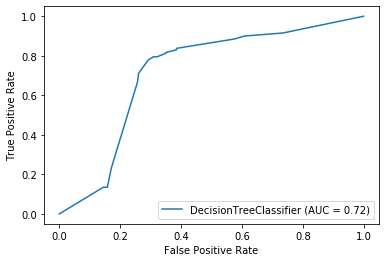

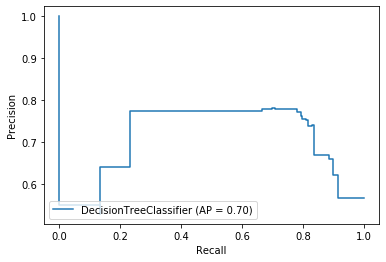

In [7]:
test_model(shallow_dt, X_test, y_test)
display(plot_roc_curve(shallow_dt, X_test, y_test))
display(plot_precision_recall_curve(shallow_dt, X_test, y_test))

#### Deep decision tree

Accuracy: 0.7215909090909091
Recall: 0.765
Precision: 0.75
F1: 0.7574257425742573
Log-loss: 9.616025187983485


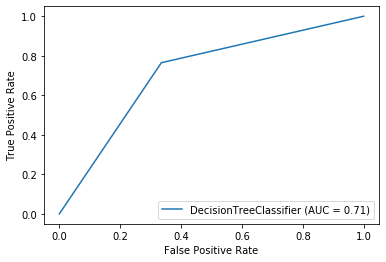

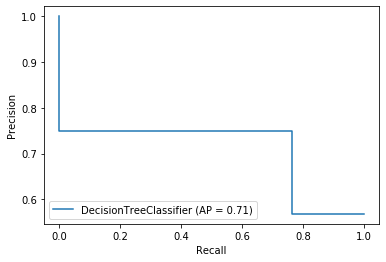

In [8]:
test_model(deep_dt, X_test, y_test)
display(plot_roc_curve(deep_dt, X_test, y_test))
display(plot_precision_recall_curve(deep_dt, X_test, y_test))

#### Random forest of shallow trees

Accuracy: 0.7997159090909091
Recall: 0.805
Precision: 0.8363636363636363
F1: 0.8203821656050955
Log-loss: 6.917638986250722


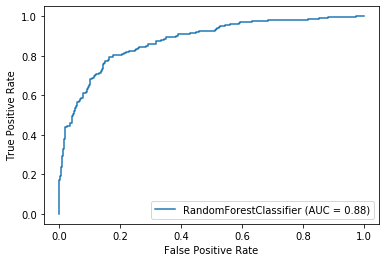

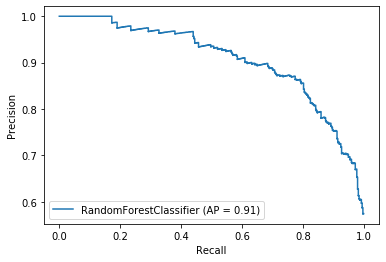

In [9]:
test_model(shallow_rf, X_test, y_test)
display(plot_roc_curve(shallow_rf, X_test, y_test))
display(plot_precision_recall_curve(shallow_rf, X_test, y_test))

#### Random forest of deep trees

Accuracy: 0.8039772727272727
Recall: 0.8175
Precision: 0.8341836734693877
F1: 0.8257575757575758
Log-loss: 6.770458972060564


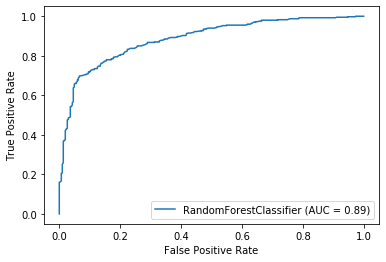

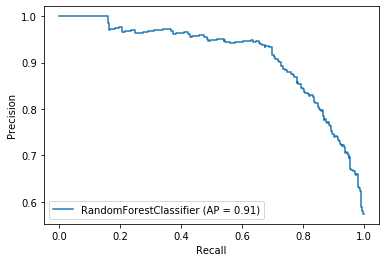

In [10]:
test_model(deep_rf, X_test, y_test)
display(plot_roc_curve(deep_rf, X_test, y_test))
display(plot_precision_recall_curve(deep_rf, X_test, y_test))

#### FN-avoiding classifier

In [11]:
class FNAvoidingClassifier:
    def __init__(self, clf, X, y):
        self.clf = clf
        y_pred_proba = self.clf.predict_proba(X)[:, 1]
        min_pos_proba = y_pred_proba[y == 1].min()
        self.threshold = min_pos_proba - 1e-10
        
    def predict(self, X):
        y_pred_proba = self.clf.predict_proba(X)[:, 1]
        y_pred = (y_pred_proba > self.threshold).astype(np.int)
        return y_pred

We will estimate the optimal threshold on the validation set to avoid the leakage of data from test set into the classifier.

In [12]:
fn_avoiding_deep_rf = FNAvoidingClassifier(deep_rf, X_val, y_val)

Now this test should be quite fair.

In [13]:
test_model(fn_avoiding_deep_rf, X_test, y_test)

Accuracy: 0.6264204545454546
Recall: 0.9925
Precision: 0.604261796042618
F1: 0.751182592242195
Log-loss: 12.903275692036026
